In [2]:
ENV["JULIA_PKG_USE_CLI_GIT"] = "true"
cd("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/")
pwd()

import Pkg
Pkg.activate(".")
# Pkg.add(Pkg.PackageSpec(;name="ACEpotentials", version="0.6.7"))
using ACEpotentials

  Activating project at `/leonardo_work/Sis25_degironc_0/apol/aceconverge2025`


# Playground

In [ ]:
basis_bin = Dict()
orders = [2,3]
degrees = [[10,5],[10,5,3]]
labels = ["10.5","10.5.3"]
# orders = [2,2,3,4]
# degrees = [[14,12],[16,12],[16,12,8],[16,12,8,4]]
# labels = ["14.12","16.12","16.12.8","16.12.8.4"]
# degrees = [[40,9],[40,9,8],[40,9,8,7]]
# labels = ["40.9","40.9.8","40.9.8.7"]
# orders = [2,2,3,3]
# degrees = [[45,16],[46,16],[46,16,12],[46,20,14]]
# labels = ["45.16","46.16","46.16.12","46.20.14"]


for (i,ord) in enumerate(orders)
    basis = ACE1x.ace_basis(
        elements = [:C],
        order = ord,
        # totaldegree = degrees[i],
        totaldegree = 20,
        rcut = 6.0,
        r0 = 1.0,
        pure = false)
    # basis_bin[labels[i]] = basis
    # println("basis_bin[\"" * labels[i] * "\"]")
    println(length(basis))
end


294
1809
5456


# Trial dim

In [ ]:
# dataset 
data_file = "/leonardo_work/Sis25_degironc_0/Tr124_dim.xyz"
data = read_extxyz(data_file);

LoadError: file /leonardo_work/Sis25_degironc_0/apol/Tr124_dim.xyz cannot be opened for reading

In [ ]:
# basis construction with purification (pure = true) or otherwise
r0 = 1.5
basis = ACE1x.ace_basis(
    elements = [:C],
    order = 2,
    totaldegree = 10,
    rcut = 7.0,
    r0 = r0,
    pure = true
)
@show length(basis)

LoadError: InterruptException:

In [ ]:
Vref = OneBody(:C => -245.44385736)

# regression weights
# weights = Dict(
#     "FLD_TiAl" => Dict("E" => 60.0, "F" => 1.0, "V" => 1.0 ),
#     "TiAl_T5000" => Dict("E" => 5.0, "F" => 1.0, "V" => 1.0)
# )
weights = Dict(
    "shaiducarbon" => Dict("E" => 1.85, "F" => 1.0)
    
)

Dict{String, Dict{String, Float64}} with 1 entry:
  "shaiducarbon" => Dict("E"=>1.85, "F"=>1.0)

In [ ]:
# Basis precomputation 
datakeys = (energy_key = "energy", force_key = "force")
train = [ACEpotentials.AtomsData(t; weights=weights, v_ref=Vref, datakeys...) for t in data]
A, Y, W = ACEfit.assemble(train, basis) # A, Y, W are needed for the solver. See equation below.
P = smoothness_prior(basis; p=4);

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (854, 51).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [ ]:
# Potential 1
solver = ACEfit.LSQR(damp = 1e-2, atol = 1e-6, P = P) # damp = lambda 
results = ACEfit.solve(solver, W .* A, W .* Y) # W .* A is element-wise multiplication of W and A
pot_1 = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))

damp  0.01
atol  1.0e-6
maxiter  100000
Converged

┌ Warning: Need to apply preconditioner in LSQR.
└ @ ACEfit ~/.julia/packages/ACEfit/IW8vD/src/solvers.jl:95


 after 18 iterations.
relative RMS error  0.017411714536787613


JuLIP.MLIPs.SumIP{Any}(Any[OneBody{Float64}(Dict(:C => -245.44385736)), PolyPairPot{Float64, ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1, 0}([60.82150888596024, -107.76630728966568, 128.99107446918865, -122.53761941275778, 114.52399175351684, -93.21677276107971, 68.63941707379006, -41.29809623508968, 18.542051584709743, -4.866236628908764], PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPo

In [ ]:
# Potential 2 to highlight advantage of acebasis
weights["shaiducarbon"]["E"] = 500.0
W = ACEfit.assemble_weights(train)
solver = ACEfit.LSQR(damp = 1e-2, atol = 1e-6, P = P)
results = ACEfit.solve(solver, W .* A, W .* Y)
pot_2 = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))

damp  0.01
atol  1.0e-6
maxiter  100000
Converged after 18 iterations.
relative RMS error  0.0056854398156393595


[ Info: Assembling full weight vector.
┌ Warning: Need to apply preconditioner in LSQR.
└ @ ACEfit ~/.julia/packages/ACEfit/IW8vD/src/solvers.jl:95


JuLIP.MLIPs.SumIP{Any}(Any[OneBody{Float64}(Dict(:C => -245.44385736)), PolyPairPot{Float64, ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1, 0}([9.56929033776388, -23.73847099226515, 31.86488251807065, -24.94701030245997, 25.92934690735256, -20.180142314604314, 15.583558325293476, -9.320807614255388, 4.524725230817843, -1.4746101217923413], PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPolyB

# Validation/testing

In [ ]:
test_data_dir = "/leonardo_work/Sis25_degironc_0/apol/Val123_dim.xyz"
test_data = read_extxyz(test_data_dir);

In [ ]:
test = [ACEpotentials.AtomsData(t; weights=weights, v_ref=Vref, datakeys...) for t in test_data]

@info("Test Error Tables")
@info("First Potential")
err1 = ACEpotentials.linear_errors(train, pot_1);

[ Info: Test Error Tables
[ Info: First Potential
[ Info: RMSE Table


┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │ 165.288 │    1.470 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │ 165.288 │    1.470 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘
┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │ 139.360 │    1.109 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │ 139.360 │    1.109 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘


[ Info: MAE Table


In [ ]:
err1["rmse"]["shaiducarbon"]["F"]

1.4698637181764689

In [ ]:
err1["rmse"]

Dict{String, Any} with 2 entries:
  "set"          => Dict("V"=>0.0, "E"=>0.165288, "F"=>1.46986)
  "shaiducarbon" => Dict("V"=>0.0, "E"=>0.165288, "F"=>1.46986)

In [ ]:
typeof(err1["rmse"])

Dict{String, Any}

In [ ]:
save_dict("err1.json",err1["rmse"])

In [ ]:
qwer = load_dict("err1.json")
print(qwer,"\n", typeof(qwer))

Dict{String, Any}("set" => Dict{String, Any}("V" => 0.0, "E" => 0.165287944228281, "F" => 1.4698637181764689), "shaiducarbon" => Dict{String, Any}("V" => 0.0, "E" => 0.165287944228281, "F" => 1.4698637181764689))
Dict{String, Any}

In [ ]:
@info("Second Potential:")
ACEpotentials.linear_errors(train, pot_2);

┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │  66.950 │    2.744 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │  66.950 │    2.744 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘
┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │  50.192 │    1.064 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │  50.192 │    1.064 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘


[ Info: Second Potential:
[ Info: RMSE Table
[ Info: MAE Table


# Dimers

In [10]:
using Plots, LaTeXStrings, DelimitedFiles

In [14]:
pwd()

"/leonardo_work/Sis25_degironc_0/apol/aceconverge2025"


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This po

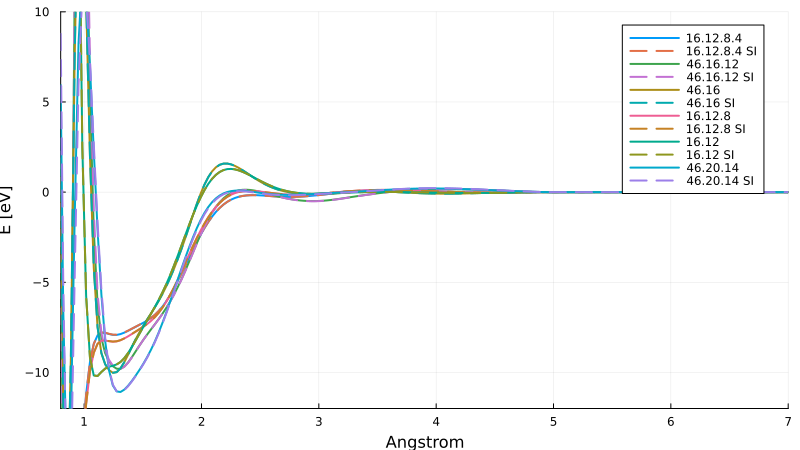

In [17]:
## Basis check 
# basisvals = ["10.5", "40.10", "46.16", "40.10.9", "46.16.12", "46.20.14", "46.24.16", "40.10.9.8", "46.20.14.10"]
basisvals = ["16.12","46.16","16.12.8","46.16.12","46.20.14","16.12.8.4"]
# basisvals = ["16.12.8","46.20.14"]
# basisvals = ["40.10.9"]
pots_bybasis = Dict()
pots_bybasis_si = Dict()
for basis in basisvals
    pots_bybasis[basis] = load_potential("acejulia/Tr1k_n_purify/$basis/ecost50.0/damp1.0e-8/potential_BLR.json");
    pots_bybasis_si[basis] = load_potential("acejulia/Tr1k_n/$basis/ecost50.0/damp1.0e-8/potential_BLR.json");
    # pots_LSQR[basis] = load_potential("acejulia/Tr100_n/$basis/ecost50.0/damp1.0e-8/potential.json");
end

plt_dim = plot(
    legend = :topright, 
    xlabel = "Angstrom", ylabel = "E [eV]",
    xlims = (0.8, 7), ylims = (-12, 10),
    # xlims = (0.8, 7), ylims = (-0.5,0.5),
    size= (800,450))

for (basis, pot) in pots_bybasis
    # D = ACEpotentials.dimers(pots_bybasis[basis], [:C,], rr = range(0.529177, 7.0, length=200))
    # D_si = ACEpotentials.dimers(pots_bybasis_si[basis], [:C,], rr = range(0.529177, 7.0, length=200))
    # x = D[(:C,:C)][1]
    # y_diff = D_si[(:C,:C)][2] .- D[(:C,:C)][2]
    # plot!(plt_dim, x, y_diff, lw=2, label = "basis = $basis difference")

    D = ACEpotentials.dimers(pots_bybasis[basis], [:C,],rr = range(0.529177, 7.0, length=200));
    plot!(plt_dim, D[(:C,:C)]..., lw=2, label = "$basis")
    D_si = ACEpotentials.dimers(pots_bybasis_si[basis], [:C,],rr = range(0.529177, 7.0, length=200))
    plot!(plt_dim, D_si[(:C,:C)]..., lw=2, linestyle=:dash,label = "$basis SI")
end

plt_dim


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.



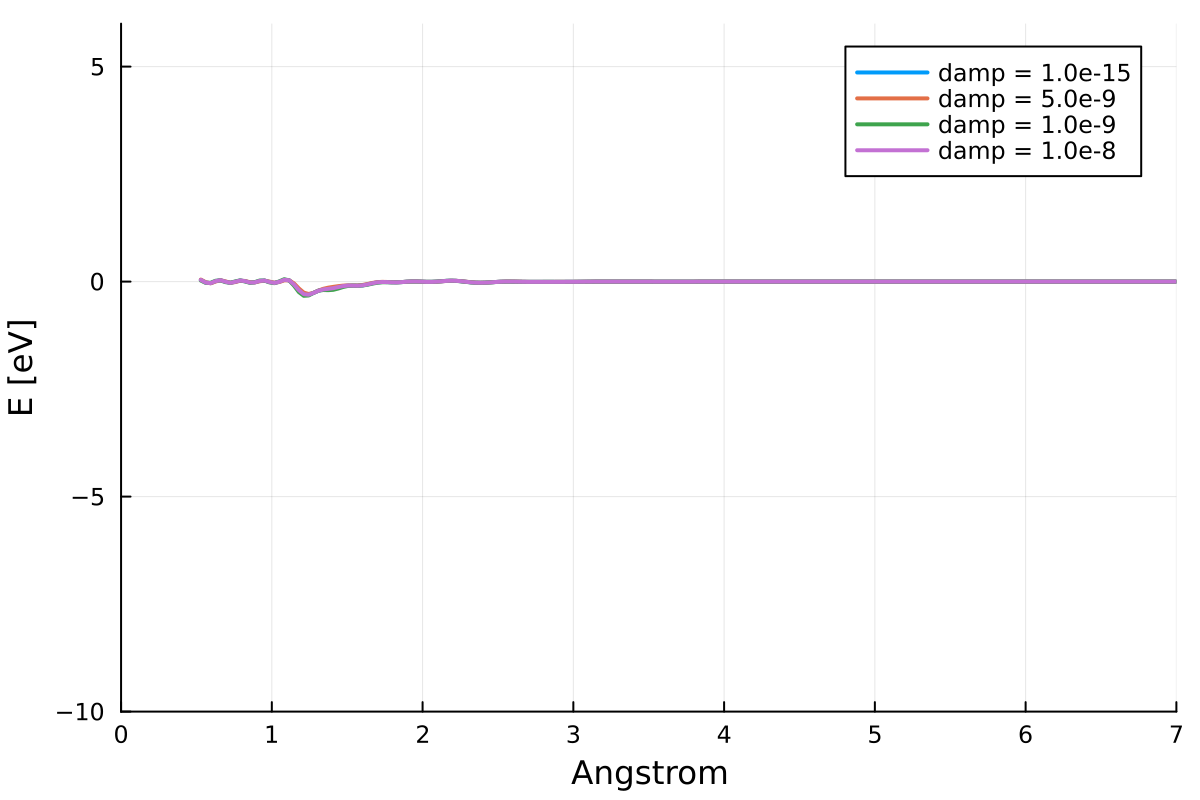

In [ ]:
## Tolerance check
dampvals = ["1.0e-15", "1.0e-9", "5.0e-9", "1.0e-8"]
pots_bydamp = Dict()
for damp in dampvals
    pots_bydamp[damp] = load_potential("acejulia/Tr10k_n_purify/46.16.12/ecost50.0/damp$damp/potential.json");
end

plt_dim = plot(
    legend = :topright, 
    xlabel = "Angstrom", ylabel = "E [eV]",
    xlims = (0, 7), ylims = (-10, 6),
    dpi=200)

for (damp, pot) in pots_bydamp
    D = ACEpotentials.dimers(pots_bydamp[damp], [:C,], rr = range(0.529177, 7.0, length=200))
    plot!(plt_dim, D[(:C,:C)]..., lw=2, label = "damp = $damp")
end

plt_dim


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:



JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.


This potential was saved with following versions:

JuLIP v

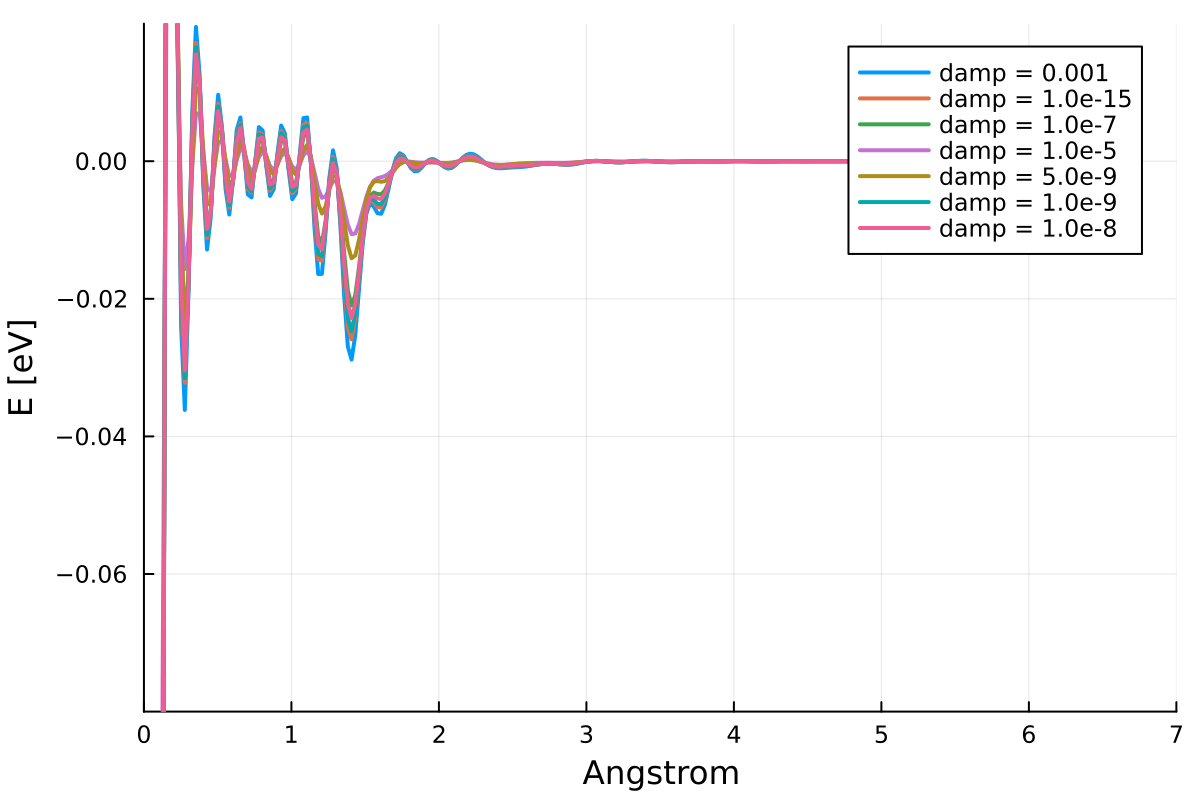

In [ ]:
## Tolerance check
dampvals = ["1.0e-15", "1.0e-9", "5.0e-9", "1.0e-8", "1.0e-7", "1.0e-5", "0.001"]
pots_bydamp = Dict()
for damp in dampvals
    pots_bydamp[damp] = load_potential("acejulia/Tr1k_n_purify/46.20.14.10/ecost50.0/damp$damp/potential.json");
end

plt_dim = plot(
    legend = :topright, 
    xlabel = "Angstrom", ylabel = "E [eV]",
    xlims = (0, 7), ylims = (-0.08, 0.02),
    dpi=200)

for (damp, pot) in pots_bydamp
    D = ACEpotentials.dimers(pots_bydamp[damp], [:C,])
    plot!(plt_dim, D[(:C,:C)]..., lw=2, label = "damp = $damp")
end

plt_dim

In [ ]:
@doc save_potential

```
save_potential( fname, potential::ACE1x.ACE1Model; save_version_numbers=true, meta=nothing)
```

Save ACE potentials. Prefix is either .json, .yml or .yace, which also determines file format.

# Kwargs

  * save*version*numbers=true  : If true save version information or relevant packages
  * `meta=nothing`             : Seve some metadata with the potential (needs to be `Dict{String, Any}`)


In [ ]:
@which save_potential

ACEpotentials

In [ ]:
save_potential("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/test_pot.json", pot_1)